In [2]:
# Installations
#!pip install "c:\\Users\\kkn\\Downloads\\opencv_python-3.4.1-cp36-cp36m-win_amd64.whl"
#!pip install imutils

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

In [4]:
class Step:
    def __init__(self, debug=False):
        self.debug = debug
    def invoke(self, frame):
        return frame

class RotationStep(Step):
    def __init__(self, debug=False):
        self.debug = debug
    
    def invoke(self, frame):
        
        ret = imutils.rotate(frame, 90)
        
#        angle90 = 90
#        scale = 1.0
#        (h, w) = frame.shape[:2]
#        center = (h / 2, w / 2)
#        self.R = cv2.getRotationMatrix2D(center, angle90, scale)
#        ret = cv2.warpAffine(frame, self.R, (h, w))
        
        if(self.debug):
            plt.subplot(131),plt.imshow(frame),plt.title('Input')
            plt.subplot(132),plt.imshow(ret),plt.title('Output')
            #plt.subplot(133),plt.imshow(dst),plt.title('Output')
            plt.show()
        
        return ret

class PerspectiveStep(Step):
    def __init__(self, points, debug=False):
        self.points = points
        self.debug = debug
    
    def invoke(self, frame):
        ret = self.four_point_transform(frame, np.array(self.points))

        if(self.debug):
            plt.subplot(121),plt.imshow(frame),plt.title('Input')
            plt.subplot(122),plt.imshow(ret),plt.title('Output')
            plt.show()

        return ret
    
    def order_points(self, pts):
        rect = np.zeros((4, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
    
    def four_point_transform(self, image, pts):
        rect = self.order_points(pts)
        (tl, tr, br, bl) = rect

        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

        # compute the perspective transform matrix and then apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

        # return the warped image
        return warped
    

class Camera:
    def __init__(self, path):
        self.cap = cv2.VideoCapture(path)
        self.steps = []
    
    def addStep(self, step):
        self.steps.append(step)
    
    def pipeline(self, frame):
        ret = frame
        for step in self.steps:
            ret = step.invoke(ret)
        return ret
    
    def nextFrame(self):
        ret, frame = self.cap.read()
        processed = self.pipeline(frame)
        return processed
    
    def finalize(self):
        self.cap.release()
        
    def run(self):
        #cv2.namedWindow("pp")
        #cv2.resizeWindow("pp", 1080, 1920)
        count = 0
        while self.cap.isOpened():
            frame = self.nextFrame()
            cv2.imshow('pp',frame)
            #cv2.imwrite("frame%d.jpg" % count, frame)
            count = count + 1
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

In [5]:
class AnchorProvider:
    def getAnchors(self):
        return []

class UserAnchorsProvider(AnchorProvider):
    
    def click_and_crop(self, event, x, y, flags, param):
        global points
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points.append((x, y))
            print("Clicky:", (x, y))
        
    def __init__(self, cam):
        self.camera = cam
        self.points = []
    
    def getAnchors(self):
        frame = self.camera.nextFrame()
        clone = frame.copy()
        cv2.namedWindow("image") #, cv2.WINDOW_NORMAL)
        cv2.resizeWindow("image", 1080, 1920)
        cv2.setMouseCallback("image", self.click_and_crop)      

        while True and len(self.points) < 4:
            if(len(self.points)>0):
                prev = None
                for cur in self.points:
                    if (prev):
                        cv2.line(clone, prev, cur, (1,0,0))
                    radius = 3
                    color = 0xFF0000
                    cv2.circle(clone, cur, radius, color, thickness=1, lineType=8, shift=0)
                    prev = cur

            cv2.imshow("image", clone)
            key = cv2.waitKey(1) & 0xFF
            if key == ord("r"):
                image = clone.copy()
            elif key == ord("c"):
                break
        return self.points


Clicky: (741, 519)
Clicky: (1009, 243)
Clicky: (1207, 266)
Clicky: (1097, 597)


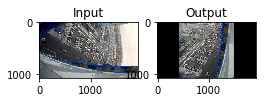

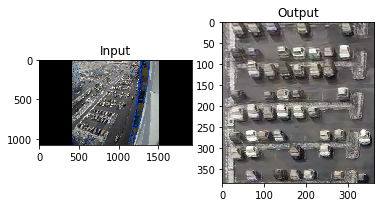

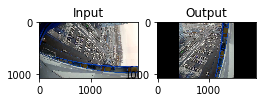

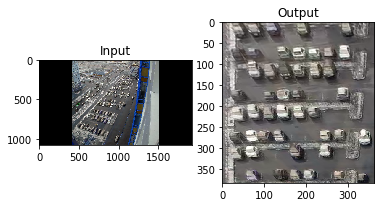

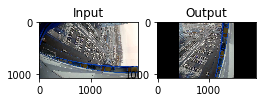

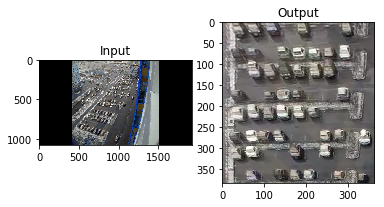

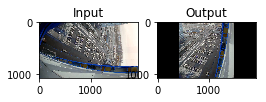

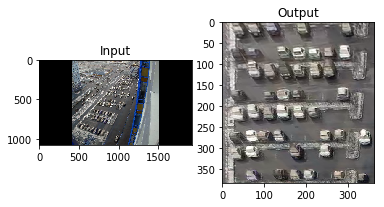

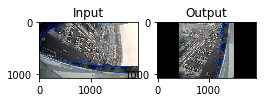

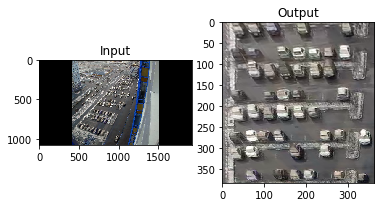

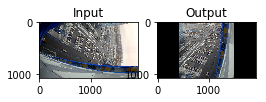

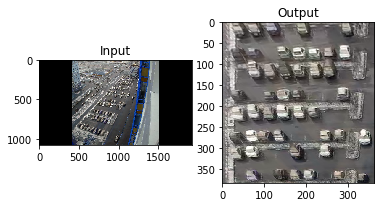

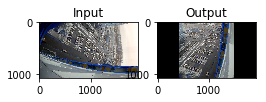

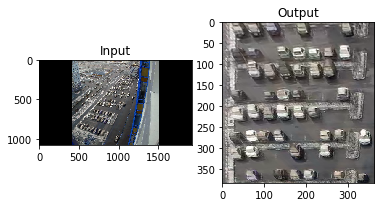

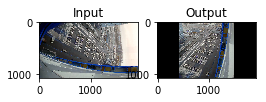

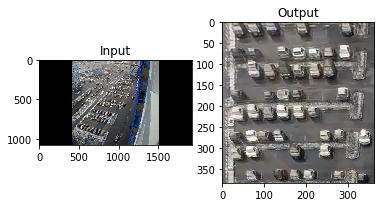

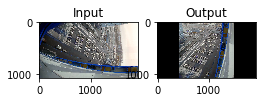

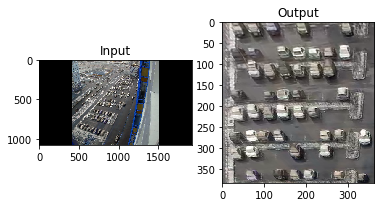

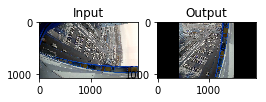

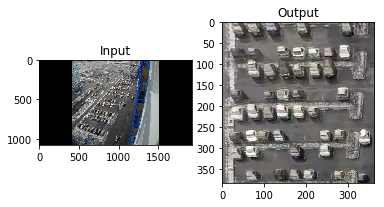

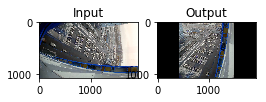

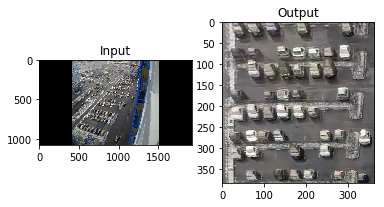

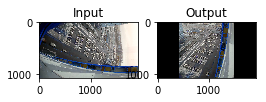

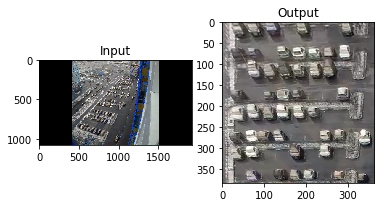

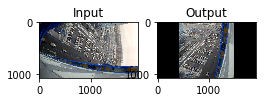

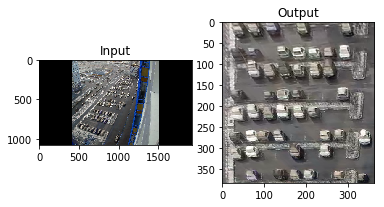

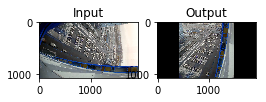

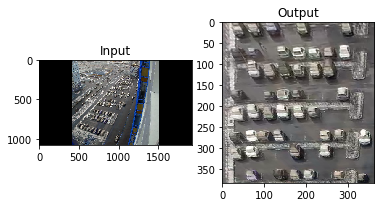

In [6]:
cam = Camera(r'c:\\Dropbox\\parking\\2017_0310_112547_001.MP4')
cam.addStep(RotationStep())
pointsProv = UserAnchorsProvider(cam)
points = pointsProv.getAnchors()
cam.finalize()
cv2.destroyAllWindows()

cam = Camera(r'c:\\Dropbox\\parking\\2017_0310_112547_001.MP4')
cam.addStep(RotationStep(debug=True))
cam.addStep(PerspectiveStep(points, debug=True))
cam.run()


cam.finalize()
cv2.destroyAllWindows()